In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde as GKDE
from scipy.stats import uniform, norm, beta
from mpl_toolkits import mplot3d
import scipy.io as sio

Summix function $f(\pmb{\pi})=\pi_1\cdot \pmb{p}_1+\pi_2 \cdot \pmb{p}_2$, where $\pmb{p}_1$ is vector of allele frequency from population 1 or $AF_{ref,1}$ and $\pmb{p}_2$ is vector of allele frequency from population 2 or $AF_{ref,2}$. $\pmb{\pi} \in [-1,1]\times[0,0.5]$. Observed data is assumed $N\left( 0.5625,0.1^2\right)$. Initial distributions are both uniform over the respective domains.

In [2]:
## given data ##
obs_val = np.random.normal(loc=0.5625, scale=0.1, size=(2,1000)) # observed values 
obs_dens = GKDE(obs_val) # observed density
def QoI(pi1, pi2, AF1, AF2): # defining QoI map
    return(pi1*AF1.transpose()+pi2*AF2.transpose())

In [3]:
## initial samples and pushforward samples ##
init_val = np.random.dirichlet([1, 1], size=1000) # initial samples - try alpha =1 
init_val_AF1 = np.random.normal(.826, .0011, (1000,2)) # initial samples - try beta distribution
init_val_AF2 = np.random.normal(.174, .0011, (1000,2)) # initial samples - try actual or binomial
Q_init_val = QoI(init_val[:,0],init_val[:,1],init_val_AF1,init_val_AF2) # computing QoI on intial samples
init_push = GKDE(Q_init_val) # pushforward of initial

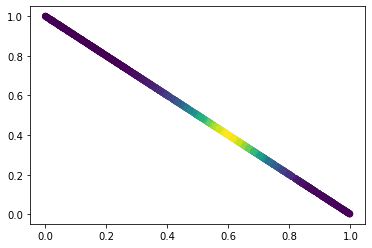

In [4]:
obs_dens_plt = obs_dens(Q_init_val)
plt.scatter(init_val[:,0],init_val[:,1],c=obs_dens_plt)

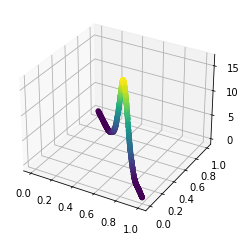

In [5]:
ax = plt.axes(projection='3d')
ax.scatter3D(init_val[:,0], init_val[:,1], obs_dens_plt, c=obs_dens_plt);

In [6]:
## rejection sampling for update ##
def rejection_sampling(r): # creating indexes for samples to keep from initial samples using rejection sampling 
    N = r.size 
    reject_prob = np.random.uniform(low=0, high=1, size=N) 
    r = r/np.max(r)
    idx = np.where(r >= reject_prob)[0]
    return idx
r = np.divide(obs_dens(Q_init_val), init_push(Q_init_val)) # computing RN weight
samples_to_keep = rejection_sampling(r) # performing rejection sampling
accept_rate = samples_to_keep.size/init_val.shape[1] # computing acceptance rate from performing rejection sampling
print(accept_rate) # printing acceptance rate 
print(np.mean(r)) # printing mean RN weight; should be close to 1

4.5
0.017462016738632045


In [7]:
## update ##
updated_val = init_val[:,samples_to_keep] # samples from updated parameter density
updated_Q_val = Q_init_val[samples_to_keep] # samples from updated QoI density
updated_Q_dens = GKDE(Q_init_val, weights=r) # updated QoI density

IndexError: index 65 is out of bounds for axis 1 with size 2

In [ ]:
updated = GKDE(init_val, weights=r)
updated_plt = updated([init_val[0],init_val[1]])
plt.scatter(init_val[0],init_val[1],c=updated_plt)

In [ ]:
ax = plt.axes(projection='3d')
ax.scatter3D(init_val[0], init_val[1], updated_plt, c=updated_plt);

In [ ]:
plt.scatter(updated_val[0],updated_val[1])

In [ ]:
## plots ##
plot_start = -.05
plot_end = 1.5
Q_plot_val = np.linspace(plot_start, plot_end, num=100) # creating QoI values for plots
plt.clf() # clearing plots

init_push_plot_val = init_push(Q_plot_val) # initial pushforward values for plots
obs_plot_val = obs_dens(Q_plot_val) # observed values for plots
updated_Q_plot_val = updated_Q_dens(Q_plot_val) # updated QoI values for plots

obs_plot = plt.plot(Q_plot_val, obs_plot_val, 'r-', linewidth=4, label="Observed") 
init_push_plot = plt.plot(Q_plot_val, init_push_plot_val, 'b-', linewidth=4, label="Pushforward of Initial")
updated_Q_plot = plt.plot(Q_plot_val, updated_Q_plot_val, 'k--', linewidth=4, label="Updated")
plt.xlim([plot_start, plot_end])
plt.xlabel("QoI")
plt.legend()
plt.show()

$\textbf{Below is some code for example 6.2 from the 2018 data consistent inversion paper.}$

Example with $$Q(\pmb{x})=\left\{ \begin{array}{c c} q_1(\pmb{x})-2, & 3x_1+2x_2\geq 0 \text{ and } -x_1+0.3x_2<0 \\ 2q_2(\pmb{x}), & 3x_1+2x_2\geq 0 \text{ and } -x_1+0.3x_2\geq 0 \\ 2q_1(\pmb{x})+4, & \left( x_1+1\right)^2+\left( x_2+1\right)^2<0.95^2 \\ q_1(\pmb{x}) & \text{otherwise}\end{array}\right.$$ where $q_1(\pmb{x})=\text{exp}\left( -x_1^2-x_2^2\right)-x_1^3-x_2^3$, $q_2(\pmb{x})=1+q_1(\pmb{x})+\dfrac{1}{8}\left( x_1^2+x_2^2\right)$, and $\pmb{x}\in [-1,1]^2$. Observed data is assumed to be $N\left( -2.0,0.25^2\right)$, and the initial distributions are taken to be uniform.

In [ ]:
## given data ##
obs_val = np.random.normal(loc=-2.0, scale=0.25, size=1000) # observed values 
obs_dens = GKDE(obs_val) # observed density
def q1(x1, x2):
    return(np.exp(-x1**2-x2**2)-x1**3-x2**3)
def q2(x1, x2):
    return(1+q1(x1, x2)+(x1**2+x2**2)/8)
def QoI(x1, x2): # defining QoI map
    Q = np.zeros(x1.shape[0])
    for i in list(range(0, x1.shape[0]-1)):
        if 3*x1[i] + 2*x2[i] >= 0 and -x1[i]+0.3*x2[i] < 0:
            Q[i] = q1(x1[i], x2[i])-2
        elif 3*x1[i]+2*x2[i] >= 0 and -x1[i]+0.3*x2[i] >= 0:
            Q[i] = 2*q2(x1[i], x2[i])
        elif (x1[i]+1)**2+(x2[i]+1)**2 < 0.95**2:
            Q[i] = 2*q1(x1[i], x2[i])+4
        else:
            Q[i] = q1(x1[i], x2[i])
    return(Q)

In [ ]:
## initial samples and pushforward samples ##
init_val = np.array([np.random.uniform(-1, 1, 10000), np.random.uniform(-1, 1, 10000)]) # initial samples
Q_init_val = QoI(init_val[0], init_val[1]) # computing QoI on intial samples
init_push = GKDE(Q_init_val) # pushforward of initial

In [ ]:
## rejection sampling for update ##
def rejection_sampling(r): # creating indexes for samples to keep from initial samples using rejection sampling 
    N = r.size 
    reject_prob = np.random.uniform(low=0, high=1, size=N) 
    r = r/np.max(r)
    idx = np.where(r >= reject_prob)[0]
    return idx
r = np.divide(obs_dens(Q_init_val), init_push(Q_init_val)) # computing RN weight
samples_to_keep = rejection_sampling(r) # performing rejection sampling
accept_rate = samples_to_keep.size/init_val.shape[1] # computing acceptance rate from performing rejection sampling
print(accept_rate) # printing acceptance rate 
print(np.mean(r)) # printing mean RN weight; should be close to 1

In [ ]:
## update ##
updated_val = init_val[:,samples_to_keep] # samples from updated parameter density
updated_Q_val = Q_init_val[samples_to_keep] # samples from updated QoI density
updated_Q_dens = GKDE(updated_Q_val) # updated QoI density

In [ ]:
## plots ##
plot_start = -4
plot_end = 8
Q_plot_val = np.linspace(plot_start, plot_end, num=100) # creating QoI values for plots
plt.clf() # clearing plots

init_push_plot_val = init_push(Q_plot_val) # initial pushforward values for plots
obs_plot_val = obs_dens(Q_plot_val) # observed values for plots
updated_Q_plot_val = updated_Q_dens(Q_plot_val) # updated QoI values for plots

obs_plot = plt.plot(Q_plot_val, obs_plot_val, 'r-', linewidth=4, label="Observed") 
init_push_plot = plt.plot(Q_plot_val, init_push_plot_val, 'b-', linewidth=4, label="Pushforward of Initial")
updated_Q_plot = plt.plot(Q_plot_val, updated_Q_plot_val, 'k--', linewidth=4, label="Updated")
plt.xlim([plot_start, plot_end])
plt.xlabel("QoI")
plt.legend()
plt.show()

$\textbf{Below is some code for example 6.3 from the 2018 data consistent inversion paper.}$

In [ ]:
data_set = sio.loadmat('elliptic_kde100_10K.mat')

In [ ]:
## given data ##
init_val = data_set['pp'] # initial samples
Q_init_val = data_set['qq'] # samples of pushforward
Q_init_val = Q_init_val[:,0] # using first QoI for this example
N = Q_init_val.shape[0]
init_push = GKDE(Q_init_val, 'silverman') # pushforward of initial
obs_dens_val = norm.pdf(Q_init_val, loc=0.7, scale=1.0e-2) # observed density values assumed N(0.7,0.01^2)

In [ ]:
## rejection sampling for update ##
def rejection_sampling(r): # creating indexes for samples to keep from initial samples using rejection sampling 
    N = r.size 
    reject_prob = np.random.uniform(low=0, high=1, size=N) 
    r = r/np.max(r)
    idx = np.where(r >= reject_prob)[0]
    return idx
r = np.divide(obs_dens_val, init_push(Q_init_val)) # computing RN weight
# the only things here that require the rejection sampling are computing samples_to_keep and accept_rate
samples_to_keep = rejection_sampling(r) # performing rejection sampling
accept_rate = samples_to_keep.size/init_val.shape[0] # computing acceptance rate from performing rejection sampling
idx = np.where(r>0) # replacing 0 r values with 1 for computing mean(rlog(r))
KL = np.ones(r.shape[0])
KL[idx] = r[idx] 

print('Acceptance Rate =', accept_rate)  
print('Integral of Updated Density =', np.mean(r)) 
print('KL divergence =', np.mean(KL*np.log(KL))) 

In [ ]:
## update ##
updated_val = init_val[:,samples_to_keep] # samples from updated parameter density
updated_Q_val = Q_init_val[samples_to_keep] # samples from updated QoI density
#updated_Q_dens = GKDE(updated_Q_val) # updated QoI density using rejection sampling
#updated_dens = GKDE(updated_val) # updated parameter density using rejection sampling
updated_Q_dens = GKDE(Q_init_val, weights=r) # updated QoI density - does not use rejection sampling
updated_dens = GKDE(init_val, weights=r) # updated parameter density - does not use rejection sampling
print('Mean of Updated QoI Values =', np.mean(updated_Q_val))
print('Standard Deviation of Updated QoI Values =', np.sqrt(np.var(updated_Q_val)))
# these are some other ways of computing the mean and standard deviation of the updated QoI values that don't 
# require rejection sampling
mean = sum(r*Q_init_val)/N
print('Mean Computed as Weighted Sum =', mean)
print('Standard Deviation as Weighted Sums =', np.sqrt(sum(r*Q_init_val**2)/N-mean**2))

In [ ]:
## plots ##
plot_start = 0.6
plot_end = 0.9
Q_plot_val = np.linspace(plot_start, plot_end, num=100) # creating QoI values for plots
plt.clf() # clear figure

init_push_plot_val = init_push(Q_plot_val) # initial pushforward values for plots
obs_plot_val = norm.pdf(Q_plot_val, loc=0.7, scale=1.0e-2) # observed values for plots
updated_Q_plot_val = updated_Q_dens(Q_plot_val) # updated QoI values for plots

obs_plot = plt.plot(Q_plot_val, obs_plot_val, 'r-', linewidth=4, label="Observed") 
init_push_plot = plt.plot(Q_plot_val, init_push_plot_val, 'b-', linewidth=4, label="Pushforward of Initial")
updated_Q_plot = plt.plot(Q_plot_val, updated_Q_plot_val, 'k--', linewidth=4, label="Updated")
plt.xlim([plot_start, plot_end])
plt.xlabel("QoI")
plt.legend()
plt.show()